# AML Predykcja cen domów 
---
### Use case:
 - Rozwiązywanym problemem jest predykcja cen domów na podstawie zmiennych objśniających np. powierzchnia, 
 liczba łazienek. Postawionym zadaniem jest regresja, pozwalająca na określenie prawdopodobnej wartości przykładowego
 domu.
 
 - W tym przypadku zmienną objaśnianą jest cena domu (w zbiorze kolumna "price"). Na podstawie korelacji z innymi 
 zmiennymi można dokonać predykcji i automatyzacji wyceny wartości domów, będącą pomocą dla agentów nieruchomści.

### Dataset: kc_house_data.csv
##### Link do zbioru: https://www.kaggle.com/harlfoxem/housesalesprediction
 - Wybrany został dataset stanowiący archiwum wykonanych transakcji sprzedaży domów w King County w USA. Wykonane zadanie
 regresji pozwoli zbudować model, działający wyłącznie dla danego regionu.
heatmap
wykres predykcji
opis danych

### Uruchomienie notebooka
 - utworzenie wystąpienia Machine Learning
 - utworzenie klastra
 - użycie notestów (Notebooks)
 - wczytanie notebooka "house_prices_predict.ipynb"

#### Sprawdzenie AML SDK
Importowanie AML core oraz sprawdzenie spójności wersji do wykorzystanych funkcji (eksperyment wykonano dla v.1.19.0)

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.19.0


### Importowanie bibliotek do przetworzenia danych
 - pandas - biblioteka do przetworzenia i importowania datasetu
 - matplotlib - biblioteka do tworzenia wykresów

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Importowanie danych
Dane pliku csv "kc_house_data.csv" umieszczone zostały w lokalizacji notebook-a "house_prices_predict.ipynb"

In [3]:
houses_df = pd.read_csv('kc_house_data.csv')
houses_df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Przetworzenie danych

- Wydzielenie z daty odrębnych danych przypisanych do kolumn:
  - dzień
  - miesiąc
  - rok, 
- Cel: znalezienie korelacji ceny z okresem sprzedaży domów

In [4]:
def build_time_features(vector):
    price_datetime = pd.to_datetime(vector[0])
    month_num = price_datetime.month
    day_num = price_datetime.day
    year_num = price_datetime.year
    
    return pd.Series((month_num, day_num, year_num))

houses_df[["month_num", "day_num","year_num"]] = houses_df[["date"]].apply(build_time_features, axis=1)
houses_df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_num,day_num,year_num
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1955,0,98178,47.5112,-122.257,1340,5650,10,13,2014
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,1951,1991,98125,47.7210,-122.319,1690,7639,12,9,2014
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,1933,0,98028,47.7379,-122.233,2720,8062,2,25,2015
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1965,0,98136,47.5208,-122.393,1360,5000,12,9,2014
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1987,0,98074,47.6168,-122.045,1800,7503,2,18,2015


- Wyświetlenie korelacji danych i ocena, które zmienne mają statystycznie największy wpływ na cenę mieszkań

In [5]:
houses_df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_num,day_num,year_num
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,...,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798,-0.011708,0.001939,0.010128
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,...,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447,-0.010081,-0.014670,0.003576
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,...,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244,-0.001533,-0.008031,-0.009838
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,...,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175,0.007392,-0.005304,-0.026596
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,...,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286,0.011810,-0.007246,-0.029038
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,...,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557,-0.002369,0.000634,0.005468
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,...,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269,0.014005,-0.006662,-0.022315
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,...,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703,0.008132,0.010518,-0.004165
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,...,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575,-0.005638,0.011174,0.001364
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,...,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406,0.021978,-0.004643,-0.045589


- Usunięcie zmiennych, które wykazują niewielką korelację z ceną domów lub mogą wpłynąć negatywnie na eksperyment

In [6]:
columns_to_remove = ["id", "date", "sqft_lot15", "sqft_living15", "zipcode", "yr_renovated"]
for col in columns_to_remove:
    houses_df.pop(col)
    
houses_df.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,month_num,day_num,year_num
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,47.5112,-122.257,10,13,2014
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,47.7210,-122.319,12,9,2014
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,47.7379,-122.233,2,25,2015
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,47.5208,-122.393,12,9,2014
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,47.6168,-122.045,2,18,2015


### Dane po przetworzeniu
- rozkład statystyczny zmiennych

In [7]:
prepared_houses_df = houses_df
prepared_houses_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,month_num,day_num,year_num
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,47.560053,-122.213896,6.574423,15.688197,2014.322954
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,0.138564,0.140828,3.115308,8.635063,0.467616
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,47.155900,-122.519000,1.000000,1.000000,2014.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,47.471000,-122.328000,4.000000,8.000000,2014.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,47.571800,-122.230000,6.000000,16.000000,2014.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,47.678000,-122.125000,9.000000,23.000000,2015.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,12.000000,31.000000,2015.000000


### Przygotowanie workspace AML
Importownie obiektu pozwalającego na konfigurację AML

In [8]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()

### Podział na dane uczące i testowe
- Dane uczące: 70%
- Dane testowe: 30%

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(prepared_houses_df, test_size=0.3, random_state=223)

### Przygotowanie ustawień treningowych AML
Parametry ustawień:
- "iteration_timeout_minutes" - limit czasu iteracji w minutach
- "experiment_timeout_hours" - maksymalny czas trwania eksperymentu
- "enable_early_stopping" - wczesne zakończenie dla braku znacznych zmian uczenia
- "primary_metric" - optymalizowana metryka, w tym przypadku "Korelacja Spearmana"
- "featurization" - wstępne przetwarzanie danych przez eksperymenty
- "verbosity" - logi
- "n_cross_validations" - sprawdzian krzyżowy poprawności

In [10]:
import logging

automl_settings = {
    "iteration_timeout_minutes": 10,
    "experiment_timeout_hours": 0.3,
    "enable_early_stopping": True,
    "primary_metric": 'spearman_correlation',
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "n_cross_validations": 10
}

### Konfiguracja AML
Parametry konfiguracji:
- "task" - zadanie, w tym przypadku regresji
- "training_data" - zbiór danych treningowych
- "label_column_name" - kolumna zmiennej objaśnianej

In [11]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task='regression',
                             debug_log='automated_ml_errors.log',
                             training_data=x_train,
                             label_column_name="price",
                             **automl_settings)

### Wyszukanie najlepszego modelu - trenowanie
- Eksperyment będzie wykonywał serie iteracji wykorzystując różne konfiguracje modelów, wybierając jako wynik końcowy
najlepszy z nich

In [12]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, "houses-experiment-5")
local_run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration
Running on local machine
Parent Run ID: AutoML_41eacc16-0071-4939-baa4-b6865bdd95df

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

***************************************************

### Otrzymanie modelu
- wyswietlenie informacji o najlepszym modelu dla zadania regresji

In [13]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: houses-experiment-5,
Id: AutoML_41eacc16-0071-4939-baa4-b6865bdd95df_17,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                             logger=Non

### Testowanie modelu - predykcja
- usuniecie kolumny ze zmienną objaśnianą w celu sprawdzenia predykcji modelu
- przetestowanie modelu przy pomocy wcześniej przygotowanego zbioru testowego

In [14]:
y_test = x_test.pop("price")

y_predict = fitted_model.predict(x_test)

### Wyniki zadania regresji
- obliczenie błędu RMSE definiującego odchylenie predykcji od rzeczywistych wartości domów

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = y_test.values.flatten().tolist()
rmse = sqrt(mean_squared_error(y_actual, y_predict))
rmse


119262.54889622105

- zestawienie danych rzeczywistych z predykcją w celu zobrazowania różnic

In [16]:
data = {"actual": y_actual, "predict": y_predict}
df = pd.DataFrame(data,columns=["actual","predict"])
print (df.head(10))

      actual    predict
0  792000.00  838163.77
1  610000.00  947862.60
2  327000.00  345002.26
3  465000.00  540984.25
4  460000.00  418327.48
5  629000.00  488524.53
6 2320000.00 2361056.81
7  257000.00  290622.77
8  415000.00  416229.44
9  787888.00 1014498.68


- graficzne zestawienie rzeczywistej wartości domu z predykcją

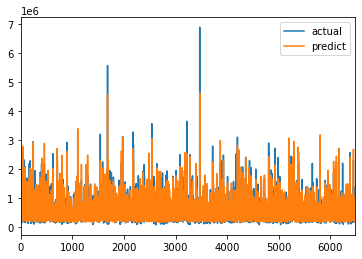

In [51]:
graph = df
graph.plot.line()
plt.show()

- wyliczenie średniego błędu bezwględnego MAPE - pozwala na określenie jak duże mogą być odchyłki od uzyskanych wyników z predykcji
- określenie dokładności modelu

In [20]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)

Model MAPE:
0.1270621848755318

Model Accuracy:
0.8729378151244682
